In [1]:
from loss_traces.results.result_processing import (
    get_lira_scores,
    create_bins,
    get_overall_tpr_at_fpr,
    get_attackr_scores,
    get_rmia_scores,
    get_trace_reduction,
)
import pandas as pd
import einops

from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np
import os

plt.style.use("plot_style.mplstyle")


In [2]:
from loss_traces.data_processing.data_processing import (
    get_no_shuffle_train_loader,
    get_num_classes,
)
from loss_traces.results.final_model_metrics import get_final_model_metrics
from loss_traces.models.model import load_model
from loss_traces.config import MODEL_DIR

import torch

exp_id = "wrn28-2_CIFAR10"

config = {
    "dataset": "CIFAR10",
    "arch": "wrn28-2",
    "batchsize": 16,
    "num_workers": 4,
    "augment": True,
    "device": "cuda:1",
}


def _initialize_model_and_data(config):
    attack_loaders = [
        get_no_shuffle_train_loader(
            config["dataset"],
            config["arch"],
            config["batchsize"],
            config["num_workers"],
        )
    ]

    if config["augment"]:
        attack_loaders.append(
            get_no_shuffle_train_loader(
                config["dataset"],
                config["arch"],
                config["batchsize"],
                config["num_workers"],
                mirror_all=True,
            )
        )

    model = load_model(config["arch"], get_num_classes(config["dataset"])).to(
        config["device"]
    )

    return model, attack_loaders


saves = torch.load(f"{MODEL_DIR}/{exp_id}/target", weights_only=False)

model, data_loader = _initialize_model_and_data(config)
model.load_state_dict(saves["model_state_dict"])

if not os.path.exists(f"fin_losses_{exp_id}_0.csv"):
    get_final_model_metrics(model, data_loader[0], metrics=["loss"]).to_csv(
        f"fin_losses_{exp_id}_0.csv"
    )
if not os.path.exists(f"grads_{exp_id}_0.csv"):
    get_final_model_metrics(model, data_loader[0], metrics=["grads"]).to_csv(
        f"grads_{exp_id}_0.csv"
    )
if not os.path.exists(f"shap_{exp_id}_0.csv"):
    get_final_model_metrics(model, data_loader[0], metrics=["shap"]).to_csv(
        f"shap_{exp_id}_0.csv"
    )


In [3]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

In [4]:
# Dictionary mapping attack names to their display labels
label_mapping = {
    "lira_score": "LiRA", 
    "loss attack": "Loss Attack", 
    "final loss": "Final loss", 
    "loss iqr (75%-25%)": "LT-IQR (75%-25%)", 
    "attackr_score": "Attack R", 
    "rmia_score": "RMIA", 
    "random_guessing": "Random guessing"
}

In [5]:

def accuracy_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    top_attack = members.sort_values(attack_score, ascending=False)
    return len(set(top_attack.head(n)['og_idx']).intersection(set(top_score.head(n)['og_idx']))) / float(n)


def precision_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]
    fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
    
    threshold = thresholds[np.where(fprs <= level)[0][-1]]

    if random_guessing:
        return sum(members[attack_score] >= threshold)/len(members), n, sum(members[attack_score] >= threshold)

    top_k = top_score.head(n)
    tp = sum(top_k[attack_score] >= threshold)

    return float(tp) / len(top_k), n, sum(members[attack_score] >= threshold)


def recall_at_k(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]

    fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
    threshold = thresholds[np.where(fprs <= level)[0][-1]]

    top_k = top_score.head(n)

    if random_guessing:
        return float(k)/100


    tp = sum(top_k[attack_score] >= threshold)
    neg = sum(members[attack_score] >= threshold)

    return tp / neg if neg else 0

def precision_on_union(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]

    benchmarks = ['lira_score', 'attackr_score', 'rmia_score']
    members = df[df['target_trained_on'] == True]
    members_dict = set()
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
            
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]

        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]  
        members_dict.update(vulnerable.index)

    if random_guessing:
        return sum(members[attack_score] >= threshold)/len(members), n, sum(members[attack_score] >= threshold)

    top_k = top_score.head(n)

    tp = len(set(top_k.index) & members_dict)

    return float(tp) / len(top_k), n, sum(members[attack_score] >= threshold)

    
def recall_on_union(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]

    benchmarks = ['lira_score', 'attackr_score', 'rmia_score']
    members = df[df['target_trained_on'] == True]
    members_dict = set()
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
            
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]

        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]  
        members_dict.update(vulnerable.index)

    top_k = top_score.head(n)

    if random_guessing:
        return float(k)/100

    tp = len(set(top_k.index) & members_dict)
    neg = len(members_dict)

    return tp / neg if neg else 0


def get_metrics_set_for_k(plots, k, levels, avg_norm_plots, base_col="avg_norm", target_col="lira_score"):
    plot_metrics = []
    for plot in plots:
        print(f"{plot=}")
        metrics_list = []
        for metric in ["auc", "overall_tpr", "precision", "recall","precision_on_union","recall_on_union"]:
            f = plot[1]
            if f is not None:
                base_col = "avg_norm"
            else:
                base_col = plot[0]
            metrics_list.append(get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric))
        plot_metrics.append(metrics_list)
    return plot_metrics



In [6]:
import sklearn

def get_dual_score(df, target_col, base_col, levels, k=1, metric="precision"):

    random_guessing = False
    if metric == "overall_tpr":
        return [get_overall_tpr_at_fpr(df, level, target_col=base_col) for level in levels]
    if metric == "auc":
        return [sklearn.metrics.roc_auc_score(df['target_trained_on'], df[base_col]) for level in levels]

    members = df[df['target_trained_on'] == True]
    
    if base_col == "random_guessing":
        top_score = members.sort_values("lira_score", ascending=False)
        random_guessing = True
    else:
        top_score = members.sort_values(base_col, ascending=False)

    if metric == "precision":
        metric_func = precision_at_k
    elif metric == "accuracy":
        metric_func = accuracy_at_k
    elif metric == "recall":
        metric_func = recall_at_k
    elif metric == "precision_on_union":
        metric_func = precision_on_union
    elif metric == "recall_on_union":
        metric_func = recall_on_union

    metrics = [metric_func(df, k, members, top_score, level, target_col, random_guessing) for level in levels]

    if metric == "precision" or metric == "precision_on_union":
        return [x[0] for x in metrics]
    if metric == "n_points":
        return [x[:1] for x in metrics]
    if metric == "n_most_vulnerable":
        return [[x[1:]] for x in metrics]
    return metrics

In [7]:
from loss_traces.results.result_processing import get_rmia_scores


def get_dual_average(dual_count, exp_id, target_col, base_col,levels, f=None, k=1, metric="precision"):
    duals = []

    for d in range(dual_count):
        tag = f'dual_track_both_{d}' if dual_count > 1 else ''
        print(tag)
        df = get_lira_scores(exp_id)
                             # + "_checkpoint_before_100", f'dual_track_both_{d}')
        df['attackr_score'] = get_attackr_scores(exp_id + tag)
        df['rmia_score'] = get_rmia_scores(exp_id + tag)
        df['loss attack'] = -get_trace_reduction(exp_id, first=-1)
        df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr") 

        
        if f is not None:
            df['avg_norm'] = f(exp_id, tag)
            df['norm_bin'] = create_bins(df)
            base_col = "avg_norm"

        duals.append([x for x in get_dual_score(df,target_col,base_col,levels, k, metric)])
    return einops.reduce(np.array(duals), "duals fprs -> fprs", reduction="mean")

In [8]:
def get_tpr_fpr_attack_comparison(dual_count, exp_id, k, levels, metric="precision"):
    metric_dict = {}
    for target_col in ["lira_score"]:

        plt.figure()
        metric_dict[target_col] = {}

        for idx, base_col in enumerate([x[0] for x in plots] + ["lira_score", "random_guessing"]):
            if target_col != base_col:
                print(f"{target_col=}{base_col=}")
                f = None
                if base_col in avg_norm_plots:
                    f = plots[idx][1]
                tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
                metric_dict[target_col][base_col] = tpr
        return metric_dict
    
label_mapping = {"lira_score": "LiRA", "final loss":"Loss", "loss iqr (75%-25%)": "LT-IQR (Ours)", "attackr_score":"Attack R", "rmia_score": "RMIA", "random_guessing":"Random guess", "rmia_1": "RMIA (2 shadow models)", "input grads":"Gradient norm"}

def plot_tpr(metric, metric_dict, log=True):
    k = 1
    levels = np.logspace(-5, 0, 100) if log else np.linspace(0, 1, 100)
    plt.figure(figsize=(10, 10))
    
    for target_col, v in metric_dict.items():
        for base_col, vals in v.items():
            if target_col != base_col and base_col in ["lira_score", "rmia_1", "final loss", "random_guessing",  "loss iqr (75%-25%)", "input grads"]:
                if base_col == "random_guessing":
                    plt.plot(levels, vals, '--', label=label_mapping[base_col], color="gray")
                else:
                    plt.plot(levels, vals, label=label_mapping[base_col])
        plt.xlabel("FPR")
        plt.ylabel(f"{metric.capitalize()}@k={k}%")
        plt.legend(loc="lower right")

  
        if log:
            plt.xscale('log')
            
        l = "log" if log else "lin"
        plt.savefig(f"./{metric}@{k}_{target_col}_fpr_{l}_{exp_id}.pdf", bbox_inches='tight')
        plt.show()    


In [9]:
import seaborn as sns

exp_id = "wrn28-2_CIFAR10"
level = 0.001



def get_matrix_attack_comparison(exp_id, level):
    """
    Compare different membership inference attacks at a specific FPR level.
    
    Args:
        exp_id: Experiment identifier
        level: FPR level for threshold calculation
        
    Returns:
        Dictionary mapping attack names to vulnerable members
    """
    # Load scores for different attacks
    df = get_lira_scores(exp_id)
    df['attackr_score'] = get_attackr_scores(exp_id)
    df['rmia_score'] = get_rmia_scores(exp_id)['rmia_2.0_new_score']
    df['loss attack'] = -get_trace_reduction(exp_id, first=-1)
    df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
    
    # List of attacks to compare
    benchmarks = ['lira_score', 'attackr_score', 'rmia_score', 'loss attack']
    
    # Filter for members (training data points)
    members = df[df['target_trained_on'] == True]
    members_dict = {}
    
    # For each attack, find vulnerable members at the specified FPR level
    for attack_score in benchmarks:
        attack_scores = df[attack_score]
        
        # Calculate threshold at the specified FPR level
        fprs, _tprs, thresholds = metrics.roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]
        print(f"{attack_score}: threshold = {threshold}")

        # Identify vulnerable members (those with scores above threshold)
        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]
        members_dict[attack_score] = vulnerable
    
    # Calculate overlap matrix between different attacks
    overlap_matrix = [[len(list(set(b.index) & set(a.index))) for k, a in members_dict.items()] for y, b in members_dict.items()]
    
    return members_dict

# Run the comparison at FPR = 0.001
for level in [0.001]:
    members_dict = get_matrix_attack_comparison(exp_id, level)
    
# Load scores for additional analysis
df = get_lira_scores(exp_id)
df['attackr_score'] = get_attackr_scores(exp_id)
df['rmia_score'] = get_rmia_scores(exp_id)['rmia_2.0_new_score']


# Calculate TPR at different FPR levels
print(get_overall_tpr_at_fpr(df, 0.00, "rmia_score"))

# Analyze overlap between different attacks
# Number of members vulnerable to all three attacks
print("LiRA & RMIA & AttackR:", len(set(members_dict["lira_score"].index) & set(members_dict["rmia_score"].index) & set(members_dict["attackr_score"].index)))

# Number of members vulnerable to LiRA and AttackR but not RMIA
print("LiRA & AttackR but not RMIA:", len(set(members_dict["lira_score"].index).intersection(set(members_dict["attackr_score"].index)) - set(members_dict["rmia_score"].index)))

# Number of members vulnerable to LiRA and RMIA but not AttackR
print("LiRA & RMIA but not AttackR:", len(set(members_dict["lira_score"].index).intersection(set(members_dict["rmia_score"].index)) - set(members_dict["attackr_score"].index)))

# Number of members vulnerable to only LiRA
print("LiRA but not RMIA or AttackR:", len(set(members_dict["lira_score"].index) - (set(members_dict["rmia_score"].index)) - set(members_dict["attackr_score"].index)))

# Number of members vulnerable to only AttackR
print("AttackR but not LiRA or RMIA:", len(set(members_dict["attackr_score"].index) - (set(members_dict["rmia_score"].index)) - set(members_dict["lira_score"].index)))

# Number of members vulnerable to AttackR and RMIA but not LiRA
print("AttackR & RMIA but not LiRA:", len(set(members_dict["attackr_score"].index).intersection(set(members_dict["rmia_score"].index)) - set(members_dict["lira_score"].index)))

# Number of members vulnerable to RMIA and LiRA but not AttackR
print("RMIA & LiRA but not AttackR:", len(set(members_dict["rmia_score"].index).intersection(set(members_dict["lira_score"].index)) - set(members_dict["attackr_score"].index)))

# Number of members vulnerable to RMIA but not LiRA or AttackR
print("RMIA but not LiRA or AttackR:", len(set(members_dict["rmia_score"].index) - (set(members_dict["lira_score"].index)) - set(members_dict["attackr_score"].index)))



lira_score: threshold = 27.983934505509914
attackr_score: threshold = 0.9983690692098915
rmia_score: threshold = 2131.0
loss attack: threshold = inf
0.01872
LiRA & RMIA & AttackR: 796
LiRA & AttackR but not RMIA: 168
LiRA & RMIA but not AttackR: 316
LiRA but not RMIA or AttackR: 1156
AttackR but not LiRA or RMIA: 33
AttackR & RMIA but not LiRA: 57
RMIA & LiRA but not AttackR: 316
RMIA but not LiRA or AttackR: 83


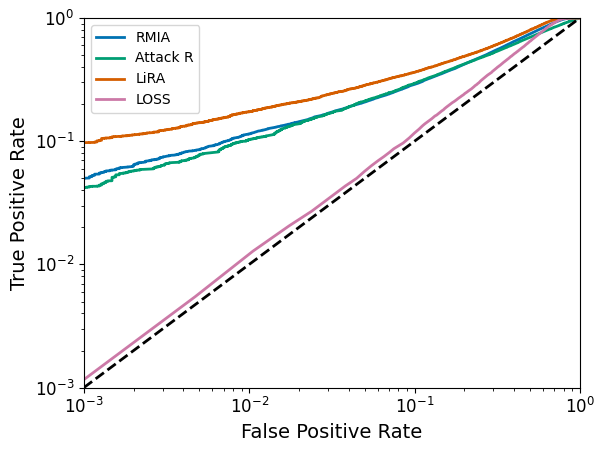

In [10]:
def print_overall_tpr_at_fpr(df: pd.DataFrame, target_col="lira_score"):

    fpr, tpr, _thresholds = metrics.roc_curve(df['target_trained_on'], df[target_col], drop_intermediate=False)
    plt.plot(fpr, tpr)
    plt.xlim(left=0)

exp_id = "wrn28-2_CIFAR10"
    
df = get_lira_scores(exp_id)
df["rmia_score"] = get_rmia_scores(exp_id)
df["attackr_score"] = get_attackr_scores(exp_id)
df["lt_iqr"] =  get_trace_reduction(exp_id, reduction="iqr") 
df["loss attack"]  = -get_trace_reduction(exp_id, first=-1, reduction=None)


label_mapping["loss attack"] = "LOSS"

plt.figure()
for a in ["rmia_score", "attackr_score", "lira_score", "loss attack"]:
    fpr, tpr, _thresholds = metrics.roc_curve(df['target_trained_on'], df[a], drop_intermediate=False)
    plt.plot(fpr, tpr, label=label_mapping[a])

plt.axline((0, 0), slope=1, color="black", linestyle="dashed")
plt.xscale("log")
plt.yscale("log")
plt.ylim(bottom=0.001)
plt.xlim(left=0.001)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig(f"./roc_curve_{exp_id}.pdf", bbox_inches="tight")
plt.show()


In [11]:

plots = [
    (
    'final loss',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
    ),
    (
    'loss iqr (75%-25%)',
    lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="iqr")
    ),
    (
     'confidence',
     lambda exp_id, t_id: pd.read_csv(f"fin_losses_{exp_id}_0.csv")["confidence"]
    ),
    (
    'input grads',
    lambda exp_id, t_id: pd.read_csv(f"grads_{exp_id}_0.csv")["input_grad_norm"]
    ),
    (
    'param grads',
    lambda exp_id, t_id: pd.read_csv(f"grads_{exp_id}_0.csv")["param_grad_norm"]
    ),
]

avg_norm_plots = [x[0] for x in plots]



def make_metrics_table(k_metrics, ks, avg_norm_plots):

    for idx,i in enumerate(ks):
        print(ks)
        plot_df = k_metrics[idx]
        plot_df = pd.DataFrame(np.array(plot_df)[:,:,0])
        plot_df.columns = [f"AUC", f"TPR@FPR={levels[0]}", f"Precision@{i}% (FPR={levels[0]})", f"Recall@{i}% (FPR={levels[0]})",f"Precision_on_union@{i}% (FPR={levels[0]})", f"Recall_on_union@{i}% (FPR={levels[0]})"]

        plot_df.index = avg_norm_plots
        base_col = plots[0][0]
        target_col = "lira_score"
        f = None

        display(plot_df)
    return k_metrics


In [12]:
k=1

exp_id = "wrn28-2_CIFAR10"

levels = np.logspace(-5, 0, 100)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)

k=1
levels = np.linspace(0, 1, 100)
print(exp_id)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)



target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='confidence'

target_col='lira_score'base_col='input grads'

target_col='lira_score'base_col='param grads'

target_col='lira_score'base_col='random_guessing'

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='confidence'

target_col='lira_score'base_col='input grads'

target_col='lira_score'base_col='param grads'

target_col='lira_score'base_col='random_guessing'

wrn28-2_CIFAR10
target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='confidence'

target_col='lira_score'base_col='input grads'

target_col='lira_score'base_col='param grads'

target_col='lira_score'base_col='random_guessing'

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col=

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
from loss_traces.results.result_processing import get_trace_reduction

exp_id = "wrn28-2_CIFAR10"

df = get_lira_scores(exp_id)
df["attackr_score"] = get_attackr_scores(exp_id)
df["rmia_score"] = get_rmia_scores(exp_id, "target", return_full_df=False)


df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
df["param_grads"] = pd.read_csv(f"grads_{exp_id}_0.csv")["param_grad_norm"]
df["input_grads"] = pd.read_csv(f"grads_{exp_id}_0.csv")["input_grad_norm"]
df["shap"] = pd.read_csv(f"shap_{exp_id}_0.csv")["shap_norm"]
df["confidence"] = pd.read_csv(f"fin_losses_{exp_id}_0.csv")["confidence"]
df["loss"] = pd.read_csv(f"fin_losses_{exp_id}_0.csv")["loss"]

members = df[df['target_trained_on'] == True]
top_score = members.sort_values(by='rmia_score', ascending=False)

level = 0.001


metrics_to_check = ['loss','lira_score', 'rmia_score', 'lt_iqr', 'confidence', 'param_grads', 'input_grads', 'shap']
# metrics_to_check = ['lira_score']

# Create a table to display results
results = []

k=1
for metric in metrics_to_check:
    top_score = members.sort_values(by=metric, ascending=False)
    if metric == "confidence":
        top_score = top_score.sort_values(by=metric, ascending=True)
    precision = precision_on_union(df, k, members, top_score, 0.001)[0]
    recall = recall_on_union(df, k, members, top_score, 0.001)
    results.append({
        'Metric': metric,
        'Precision on union': precision,
        'Recall on union': recall
    })

# Display as a table
results_df = pd.DataFrame(results)
display(results_df)

,Metric,Precision on union,Recall on union
0,loss,0.208,0.019931
1,lira_score,1.000,0.095822
2,rmia_score,1.000,0.095822
3,lt_iqr,0.932,0.089306
4,confidence,0.200,0.019164
5,param_grads,0.204,0.019548
6,input_grads,0.204,0.019548
7,shap,0.160,0.015332


In [21]:
k=1
avg_norm_plots = [x[0] for x in plots]
exp_id = "wrn28-2_CIFAR10"
levels = np.logspace(-5, 0, 100)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_log_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)

k=1
levels = np.linspace(0, 1, 100)
print(exp_id)
precision_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "precision")
recall_dict = get_tpr_fpr_attack_comparison(1, exp_id, k, levels, "recall")

file = f"precision_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(precision_dict, f, cls=NumpyEncoder)

file = f"recall_dict_lin_{exp_id}.json"
with open(file, 'w') as f: 
    json.dump(recall_dict, f, cls=NumpyEncoder)



target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='confidence'

target_col='lira_score'base_col='input grads'

target_col='lira_score'base_col='param grads'

target_col='lira_score'base_col='random_guessing'

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='confidence'

target_col='lira_score'base_col='input grads'

target_col='lira_score'base_col='param grads'

target_col='lira_score'base_col='random_guessing'

wrn28-2_CIFAR10
target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col='lira_score'base_col='confidence'

target_col='lira_score'base_col='input grads'

target_col='lira_score'base_col='param grads'

target_col='lira_score'base_col='random_guessing'

target_col='lira_score'base_col='final loss'

target_col='lira_score'base_col='loss iqr (75%-25%)'

target_col=

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
precision_dict.keys()

dict_keys(['lira_score'])

KeyError: 'rmia_1'

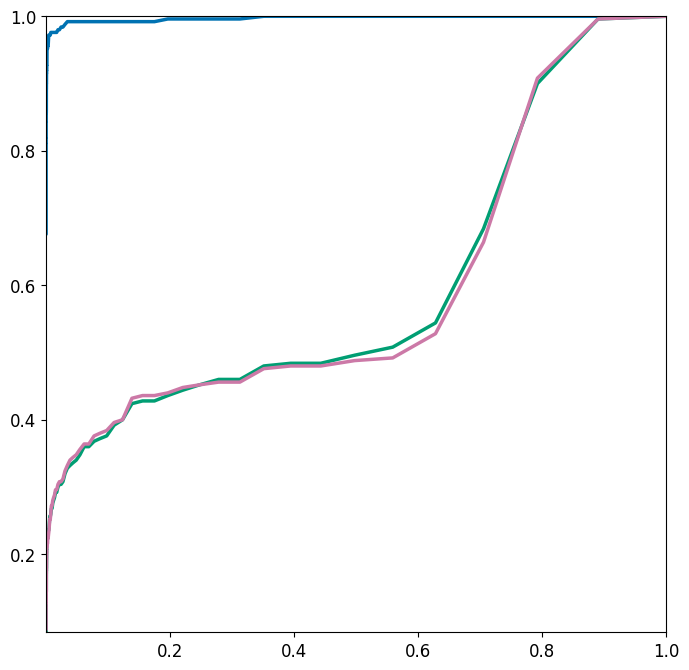

In [22]:
import json


color_mappings = {"loss iqr (75%-25%)": '#0072B2', "final loss": '#009E73', "rmia_1": '#D55E00', "input grads": '#CC79A7', "random_guessing": '#56B4E9'}

def plot_tpr(metric, metric_dict, log=True):
    k = 1
    levels = np.logspace(-5, 0, 100) if log else np.linspace(0, 1, 100)
    plt.figure(figsize=(8, 8))
    
    for target_col, v in metric_dict.items():
        for base_col in ["loss iqr (75%-25%)", "final loss", "input grads", "rmia_1", "random_guessing"]:
            vals = v[base_col]
            if target_col != base_col and base_col in ["lira_score", "rmia_1", "final loss", "random_guessing",  "loss iqr (75%-25%)", "input grads"]:
                linestyle = "-"
                if base_col == "random_guessing":
                    linestyle = ":"
                if base_col == "rmia_1":
                    linestyle = "--"
                
                plt.plot(levels, vals, linewidth=2.5, linestyle=linestyle, label=label_mapping[base_col], color=color_mappings[base_col])
        plt.xlabel("FPR")
        plt.ylabel(f"{metric.capitalize()}@k={k}%")
        plt.legend(loc="lower right", fontsize=12, prop={'size': 12})

        if log:
            plt.xscale('log')

        
            
        plt.ylim((0))
        l = "log" if log else "lin"
        plt.savefig(f"./{metric}@{k}_{target_col}_fpr_{l}_{exp_id}.pdf", bbox_inches='tight')
        plt.show()    

# exp_id = "wrn28-2_CIFAR10"
exp_id = "wrn28-2_CIFAR10"
with open(f"precision_dict_log_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
plot_tpr(metric="precision", metric_dict=precision_dict, log=True)
with open(f"precision_dict_lin_{exp_id}.json", 'r') as f:
    precision_dict = json.load(f)
plot_tpr(metric="precision", metric_dict=precision_dict, log=False)

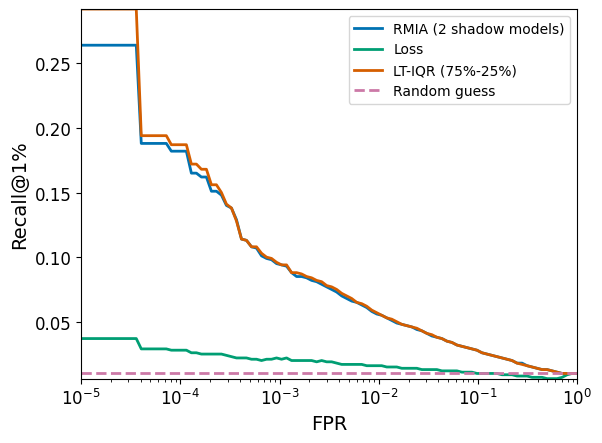

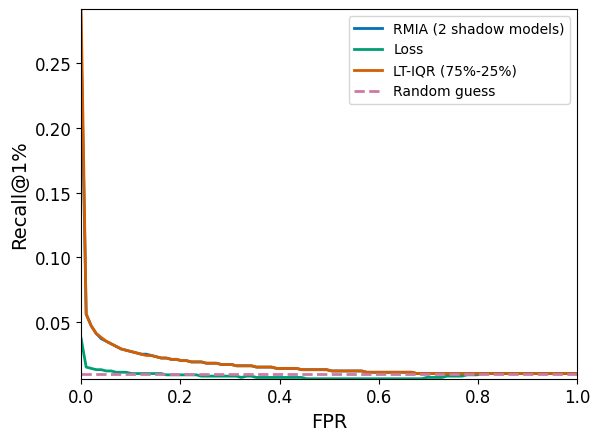

In [144]:
with open(f"recall_dict_log_{exp_id}.json", 'r') as f:
    recall_dict = json.load(f)
plot_tpr(metric="recall", metric_dict=recall_dict, log=True)
with open(f"recall_dict_lin_{exp_id}.json", 'r') as f:
    recall_dict = json.load(f)
plot_tpr(metric="recall", metric_dict=recall_dict, log=False)

In [ ]:
ks =  [1, 3, 5, 10, 50, 100]
levels = [0.001]


plots = [
            ('lira_128_online', lambda exp_id, t_id: get_lira_scores(exp_id, "target", return_full_df=False)),
            ('lira_32_online', lambda exp_id, t_id: get_lira_scores(exp_id, "target_32", return_full_df=False)),
            ('lira_8_online', lambda exp_id, t_id: get_lira_scores(exp_id, "target_8", return_full_df=False)),
            ('attackr_128', lambda exp_id, t_id: get_attackr_scores(exp_id, "target", return_full_df=False)),
            ('attackr_32', lambda exp_id, t_id: get_attackr_scores(exp_id, "target_32", return_full_df=False)),
            ('attackr_8', lambda exp_id, t_id: get_attackr_scores(exp_id, "target_8", return_full_df=False)),
            ('rmia_128', lambda exp_id, t_id: get_rmia_scores(exp_id, "target", return_full_df=False)),
            ('rmia_32', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_32", return_full_df=False)),
            ('rmia_8', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_8", return_full_df=False)),
            ('rmia_1', lambda exp_id, t_id: get_rmia_scores(exp_id, "target_1", return_full_df=False)),
            (
            'loss attack',
            lambda exp_id, t_id: -get_trace_reduction(exp_id, t_id, first=-1, reduction=None)
            ),
            ('loss iqr (75%-25%)',
            lambda exp_id, t_id: get_trace_reduction(exp_id, t_id, first=0, last=-1, reduction="iqr")
            ),
            
]

dual_count = 1
avg_norm_plots =  [x[0] for x in plots]

k_metrics = [get_metrics_set_for_k(plots , k, levels
                                   , avg_norm_plots) for k in ks]
np.save(f"k_metrics_table_attacks_{exp_id}_t.npy", np.array(k_metrics))
k_metrics = np.load(f'k_metrics_table_attacks_{exp_id}_t.npy')
make_metrics_table(k_metrics, ks, avg_norm_plots)

[1, 3, 5, 10, 50, 100]


,AUC,TPR@FPR=0.001,Precision@1% (FPR=0.001),Recall@1% (FPR=0.001),Precision_on_union@1% (FPR=0.001),Recall_on_union@1% (FPR=0.001)
lira_128_online,0.741,0.097,1.000,0.103,1.000,0.096
lira_32_online,0.727,0.066,1.000,0.103,1.000,0.096
lira_8_online,0.691,0.046,0.988,0.101,0.992,0.095
attackr_128,0.659,0.042,0.940,0.097,1.000,0.096
attackr_32,0.656,0.000,0.848,0.087,0.908,0.087
attackr_8,0.650,0.000,0.668,0.069,0.736,0.071
rmia_128,0.694,0.050,1.000,0.103,1.000,0.096
rmia_32,0.692,0.052,1.000,0.103,1.000,0.096
rmia_8,0.689,0.045,0.992,0.102,1.000,0.096
rmia_1,0.668,0.026,0.912,0.094,0.960,0.092


[1, 3, 5, 10, 50, 100]


,AUC,TPR@FPR=0.001,Precision@3% (FPR=0.001),Recall@3% (FPR=0.001),Precision_on_union@3% (FPR=0.001),Recall_on_union@3% (FPR=0.001)
lira_128_online,0.741,0.097,1.000,0.308,1.000,0.288
lira_32_online,0.727,0.066,1.000,0.308,1.000,0.288
lira_8_online,0.691,0.046,0.959,0.295,0.968,0.278
attackr_128,0.659,0.042,0.948,0.292,1.000,0.288
attackr_32,0.656,0.000,0.925,0.285,0.965,0.278
attackr_8,0.650,0.000,0.857,0.264,0.901,0.259
rmia_128,0.694,0.050,0.961,0.296,1.000,0.288
rmia_32,0.692,0.052,0.953,0.294,1.000,0.288
rmia_8,0.689,0.045,0.944,0.291,0.995,0.286
rmia_1,0.668,0.026,0.823,0.253,0.873,0.251


[1, 3, 5, 10, 50, 100]


,AUC,TPR@FPR=0.001,Precision@5% (FPR=0.001),Recall@5% (FPR=0.001),Precision_on_union@5% (FPR=0.001),Recall_on_union@5% (FPR=0.001)
lira_128_online,0.741,0.097,1.000,0.513,1.000,0.479
lira_32_online,0.727,0.066,0.988,0.507,0.990,0.474
lira_8_online,0.691,0.046,0.903,0.464,0.916,0.439
attackr_128,0.659,0.042,0.893,0.458,0.970,0.465
attackr_32,0.656,0.000,0.882,0.453,0.940,0.451
attackr_8,0.650,0.000,0.845,0.434,0.901,0.432
rmia_128,0.694,0.050,0.889,0.456,1.000,0.479
rmia_32,0.692,0.052,0.876,0.450,0.974,0.467
rmia_8,0.689,0.045,0.870,0.446,0.953,0.457
rmia_1,0.668,0.026,0.738,0.379,0.796,0.382


[1, 3, 5, 10, 50, 100]


,AUC,TPR@FPR=0.001,Precision@10% (FPR=0.001),Recall@10% (FPR=0.001),Precision_on_union@10% (FPR=0.001),Recall_on_union@10% (FPR=0.001)
lira_128_online,0.741,0.097,0.974,1.000,0.976,0.936
lira_32_online,0.727,0.066,0.882,0.906,0.894,0.857
lira_8_online,0.691,0.046,0.748,0.768,0.764,0.732
attackr_128,0.659,0.042,0.717,0.736,0.783,0.751
attackr_32,0.656,0.000,0.704,0.722,0.762,0.731
attackr_8,0.650,0.000,0.704,0.723,0.753,0.722
rmia_128,0.694,0.050,0.699,0.718,0.766,0.735
rmia_32,0.692,0.052,0.691,0.709,0.758,0.727
rmia_8,0.689,0.045,0.677,0.695,0.742,0.712
rmia_1,0.668,0.026,0.568,0.584,0.616,0.591


[1, 3, 5, 10, 50, 100]


,AUC,TPR@FPR=0.001,Precision@50% (FPR=0.001),Recall@50% (FPR=0.001),Precision_on_union@50% (FPR=0.001),Recall_on_union@50% (FPR=0.001)
lira_128_online,0.741,0.097,0.195,1.000,0.207,0.992
lira_32_online,0.727,0.066,0.195,1.000,0.206,0.989
lira_8_online,0.691,0.046,0.186,0.957,0.194,0.928
attackr_128,0.659,0.042,0.195,1.000,0.209,1.000
attackr_32,0.656,0.000,0.195,1.000,0.209,1.000
attackr_8,0.650,0.000,0.195,0.999,0.208,0.999
rmia_128,0.694,0.050,0.194,0.994,0.207,0.994
rmia_32,0.692,0.052,0.194,0.994,0.207,0.994
rmia_8,0.689,0.045,0.192,0.986,0.206,0.987
rmia_1,0.668,0.026,0.184,0.943,0.197,0.947


[1, 3, 5, 10, 50, 100]


,AUC,TPR@FPR=0.001,Precision@100% (FPR=0.001),Recall@100% (FPR=0.001),Precision_on_union@100% (FPR=0.001),Recall_on_union@100% (FPR=0.001)
lira_128_online,0.741,0.097,0.097,1.0,0.104,1.0
lira_32_online,0.727,0.066,0.097,1.0,0.104,1.0
lira_8_online,0.691,0.046,0.097,1.0,0.104,1.0
attackr_128,0.659,0.042,0.097,1.0,0.104,1.0
attackr_32,0.656,0.000,0.097,1.0,0.104,1.0
attackr_8,0.650,0.000,0.097,1.0,0.104,1.0
rmia_128,0.694,0.050,0.097,1.0,0.104,1.0
rmia_32,0.692,0.052,0.097,1.0,0.104,1.0
rmia_8,0.689,0.045,0.097,1.0,0.104,1.0
rmia_1,0.668,0.026,0.097,1.0,0.104,1.0


In [ ]:
ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
recall_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="recall", log=True)

file = f"recall_for_k_dict_{exp_id}_log.json"
with open(file, 'w') as f: 
    json.dump(recall_for_k_dict, f, cls=NumpyEncoder)

ks = [0.1, 1, 2, 3, 5]
levels = np.linspace(0, 1, 100)
recall_for_k_dict = plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="recall", log=False)

file = f"recall_for_k_dict_{exp_id}_lin.json"
with open(file, 'w') as f: 
    json.dump(recall_for_k_dict, f, cls=NumpyEncoder)

In [ ]:
with open(f"precision_for_k_dict_{exp_id}_log.json", 'r') as f:
    precision_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,precision_for_k_dict, log=True)

with open(f"precision_for_k_dict_{exp_id}_lin.json", 'r') as f:
    precision_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,precision_for_k_dict, log=False)

In [ ]:
with open(f"recall_for_k_dict_{exp_id}_log.json", 'r') as f:
    recall_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,recall_for_k_dict, log=True, metric="recall")

with open(f"recall_for_k_dict_{exp_id}_lin.json", 'r') as f:
    recall_for_k_dict = json.load(f)
plot_metrics_for_k(ks,levels,recall_for_k_dict, log=False, metric="recall")

In [ ]:
# def make_metrics_plot(plots, ks, levels):
ks= [0.1, 1, 2, 3, 5]
levels=[0.001]
avg_norm_plots = [x[0] for x in plots]
k_metrics = [get_metrics_set_for_k(plots, k, levels) for k in ks]

for i,k_val in enumerate(ks):
    plot_df = k_metrics[i]
    plot_df = pd.DataFrame(np.array(plot_df)[:,:,0])
    plot_df.columns = [f"Accuracy@{i}%", f"Precision@{i}% (FPR={levels[0]})", f"Recall@{i}% (FPR={levels[0]})"]
    plt.plot(plot_df['Accuracy@{i}%'])

In [ ]:
def plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels, metric="precision", log=True):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    
    avg_norm_plots = [x[0] for x in plots]
    
    for target_col in ["lira_score"]:
        plt.figure(figsize=(10, 6))
        
        # Create colormap
        colors = plt.cm.viridis(np.linspace(0, 1, len(ks)))
        
        for idx, base_col in enumerate([x[0] for x in plots]):
            tpr_values = []  # Store all TPR values to use for filling
            
            # First collect all TPR values
            for k_idx, k in enumerate(ks):
                if target_col != base_col:
                    f = None
                    if base_col in avg_norm_plots:
                        f = plots[idx][1]
                    tpr = get_dual_average(dual_count, exp_id, target_col, base_col, levels, f, k, metric)
                    tpr_values.append(tpr)
            # print(levels, tpr_values)
            # Fill the area between zero and the lowest curve
            plt.fill_between(levels, np.zeros_like(levels), tpr_values[0], 
                           color=colors[0],
                           alpha=0.3)
            
            # Plot fills between consecutive curves
            for i in range(len(ks) - 1):
                plt.fill_between(levels, tpr_values[i], tpr_values[i+1], 
                               color=colors[i],
                               alpha=0.3)
                
            # Plot the lines on top for better visibility
            for k_idx, k in enumerate(ks):
                if base_col in avg_norm_plots:
                    label = base_col + f"_{k}"
                plt.plot(levels, tpr_values[k_idx], 
                        label = f"k={k}%",
                        color=colors[k_idx],
                        linewidth=2)
        
        plt.xlabel("FPR")
        plt.ylabel(f"Precision@k%")
        plt.legend()
        
        if log:
            plt.xscale('log')
            l = "log"
        else:
            l = "lin"
            
        plt.grid(True, which="both", ls="-", alpha=0.2)
        plt.savefig(f"./{metric}@different_ks_filled_{target_col}_fpr_{l}.pdf", 
                   bbox_inches='tight',
                   dpi=300)
        plt.show()

In [ ]:
ks = [0.1, 1, 2, 3, 5]
levels = np.logspace(-5, 0, 100)
plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=True)

In [ ]:
ks = [0.1, 1, 2, 3, 5]
levels = np.linspace(0, 1, 100)
plot_tpr_fpr_us_comparison(dual_count, exp_id, ks, levels,metric="precision", log=False)

In [ ]:
from config import STORAGE_DIR
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from result_processing import get_lira_scores
import os
from sklearn import metrics

pcts = np.linspace(0, 1, 21)

a_pcts = [p for p in pcts if p >= 0.5]
b_pcts = [p for p in pcts if p <= 0.5]
iqr_pairs = [(a, b) for a in a_pcts for b in b_pcts]

plots = iqr_pairs 

iqr_precisions = {p: [] for p in iqr_pairs}
   
exp_id = 'wrn28-2_CIFAR10'
model_ids = ['WRN28-2']
dual_counts = [1]
   
def get_trace_reduction(exp_id: str, target_id: str = None, l: int = 0.25, r: int = 0.75, trace_type="losses"):

    base_name = exp_id + '_' + target_id if target_id else exp_id
    path = os.path.join(STORAGE_DIR, trace_type, base_name + '.pq')
    df = pd.read_parquet(path)

    return _reduction_iqr(df, l, r)
   
def _reduction_iqr(traces: pd.DataFrame, l, r) -> pd.Series:
    """Calculate interquartile range."""
    q1 = traces.quantile(r, axis=1)
    q3 = traces.quantile(l, axis=1)
    return q3 - q1

fig, axes = plt.subplots(len(exp_ids), len(plots), figsize=(1 + (5 * len(plots)),(5 * len(exp_ids))), squeeze=False)
num_bins=100
# ks = range(1,101)
# ks = np.arange(0.1, 5+.1, 0.1)
ks = [1]
for j, (left, right) in enumerate(plots):

      df = get_lira_scores(exp_id)
      df['avg_norm'] = get_trace_reduction(exp_id, l=left, r=right)

      members = df[df['target_trained_on'] == True]
      top_lira = members.sort_values('lira_score', ascending=False)
      top_score = members.sort_values('avg_norm', ascending=False)
      

      def precision_at_k(k):
         n = int(k * (len(members) / 100.0))
         fprs, tprs, _thresholds = metrics.roc_curve(df['target_trained_on'], df['lira_score'], drop_intermediate=False)
         threshold = _thresholds[np.where(fprs<=level)[0][-1]]
         # print(iqr_pairs[j], threshold)
         top_k = top_score.head(n)
         tp = sum(top_k['lira_score'] >= threshold)
         return float(tp) / len(top_k)
    
      print(left, right, iqr_pairs[j],precision_at_k(1))
      iqr_precisions[iqr_pairs[j]].append(precision_at_k(1))
      
data = np.reshape(np.array(list(iqr_precisions.values())).mean(axis=1), (len(b_pcts), len(a_pcts)))


In [ ]:
import seaborn

ax = seaborn.heatmap(data, annot=True, xticklabels=[f'{x:.2f}'for i, x in enumerate(b_pcts)], yticklabels=[f'{x:.2f}'for x in a_pcts])
ax.invert_yaxis()
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.xlabel(r'$q_1$')
plt.ylabel(r'$q_2$')

SignificanceResult(statistic=0.6156327983234907, pvalue=0.0)


Text(0.5, 0, 'IQR Rank')

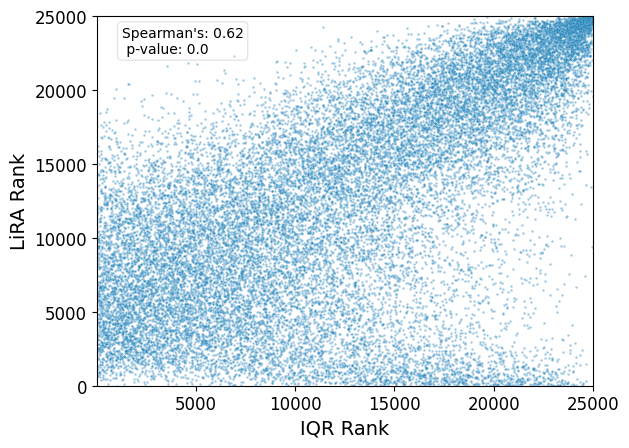

In [91]:
from sklearn.isotonic import spearmanr
import pandas as pd
import seaborn as sns

exp_id = "wrn28-2_CIFAR10"

df = get_lira_scores(exp_id, return_full_df=True)
df[f"IQR"] = get_trace_reduction(exp_id=exp_id, reduction="iqr")
df = df.loc[df["target_trained_on"] == True]

# Create 100 buckets for the IQR values
df['IQR_binned'] = pd.qcut(df['IQR'], q=10000, labels=False)
df['lira_rank'] = df['lira_score'].rank()  # Rank the lira_score
df['IQR_rank'] = df['IQR'].rank()  # Rank the IQR values


sns.scatterplot(y=df["lira_rank"], x=df["IQR_rank"], alpha=0.4, s=3)  # Plot rank of IQR against rank of lira_score
spearmans = spearmanr(df["lira_rank"], df["IQR_rank"])  # Calculate Spearman's correlation on ranks
print(spearmanr(df["lira_rank"], df["IQR_rank"]))

fpr = 0.001


# Add annotation instead of legend
plt.annotate(f"Spearman's: {spearmans.correlation.round(2)}\n p-value: {spearmans.pvalue.round(5)}", 
             xy=(0.05, 0.9), 
             xycoords='axes fraction',
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.2))

plt.ylim(0, 25000)
plt.ylabel("LiRA Rank", fontsize=14)  # Increase font size for y-axis label
plt.xlabel("IQR Rank", fontsize=14)

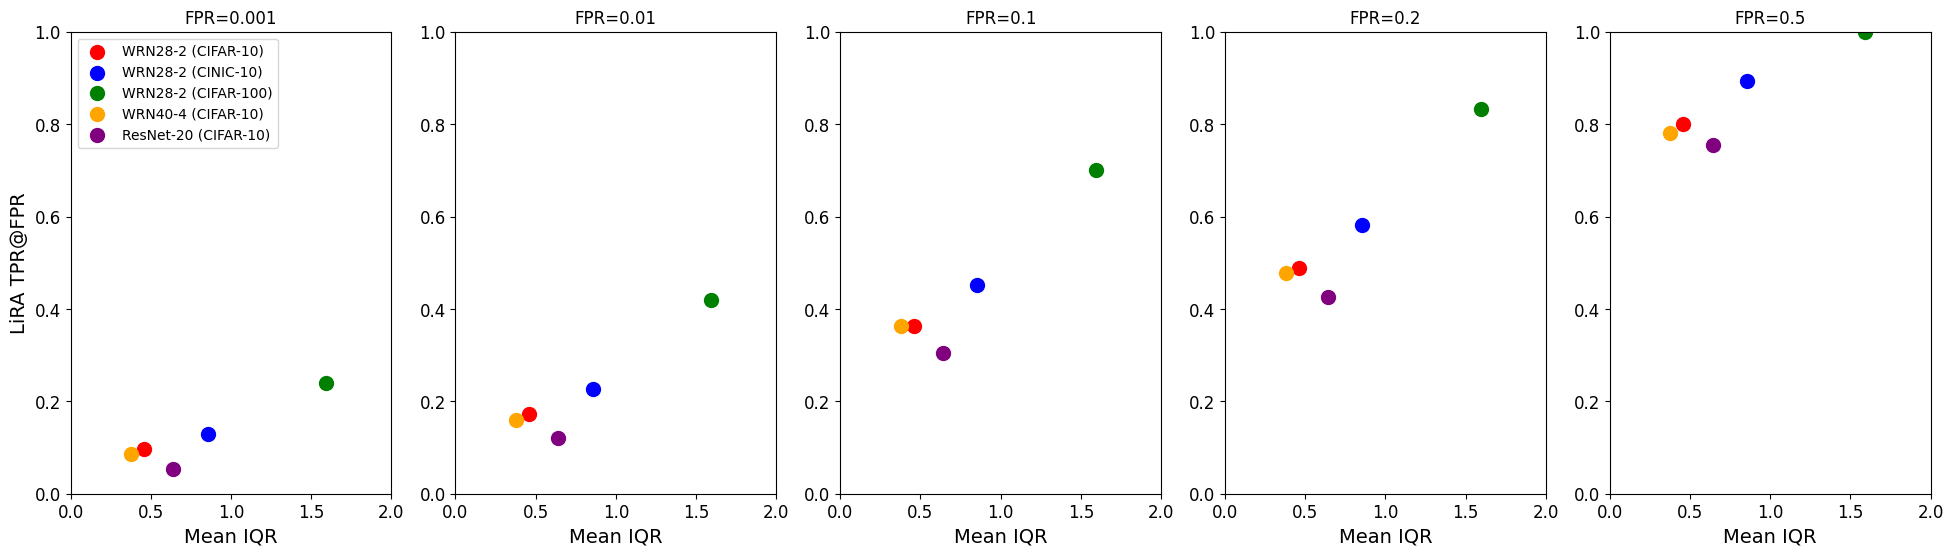

In [9]:
from results.result_processing import get_trace_reduction

colors = ['red', 'blue', 'green', 'orange', 'purple']  # Define a list of colors for each point
fpr_values = [0.001, 0.01, 0.1, 0.2, 0.5]
model_names = ["wrn28-2_CIFAR10", "wrn28-2_CINIC10", "wrn28-2_CIFAR100", "wrn40-4_CIFAR10", "rn-20_CIFAR10"]

fig, axs = plt.subplots(1, 5, figsize=(24, 6))

for idx, fpr in enumerate(fpr_values):
    tprs = []
    mean_iqrs = []
    scatter_points = []
    for i, exd in enumerate(model_names):
        df = get_lira_scores(exd, return_full_df=True)
        iqr_scores = get_trace_reduction(exp_id=exd, reduction="iqr")
        
        mean_iqrs.append(np.mean(iqr_scores))

        tpr = get_overall_tpr_at_fpr(df, query_fpr=fpr)
        # print(exd, tpr)
        tprs.append(tpr)
        
    for i in range(len(model_names)):
        scatter = axs[idx].scatter(mean_iqrs[i], tprs[i], s=100, c=colors[i], label=model_names[i])
        scatter_points.append(scatter)
    
    axs[idx].set_xlim(0, 2)
    axs[idx].set_ylim(0, 1)
    axs[idx].set_xlabel("Mean IQR")
    if idx == 0:  # Only add y-label to the first graph
        axs[idx].set_ylabel(f"LiRA TPR@FPR")
    axs[idx].set_title(f"FPR={fpr}")

# Add legend to the figure instead of just the first graph
handles, labels = axs[0].get_legend_handles_labels()
labels = ["WRN28-2 (CIFAR-10)", "WRN28-2 (CINIC-10)", "WRN28-2 (CIFAR-100)", "WRN40-4 (CIFAR-10)", "ResNet-20 (CIFAR-10)"]
axs[0].legend(handles, labels, loc='upper left', ncol=1)

plt.savefig(f"./mean_iqr_vs_tpr.pdf", bbox_inches='tight', dpi=300)